In [1]:
import torch
import sys
from dqn import Dreamer
from envs import pong, wrappers
import argparse
import yaml
import pathlib
import tools
import numpy as np
from tqdm.auto import trange
import pandas as pd
import functools

In [2]:
run = 'pong_tenth_switchback'
conf_dir = f'/home/memerling/dreamerv3-torch/'

In [3]:
parser = argparse.ArgumentParser()
configs = yaml.safe_load(
    (pathlib.Path(conf_dir) / "configs.yaml").read_text()
)

def recursive_update(base, update):
    for key, value in update.items():
        if isinstance(value, dict) and key in base:
            recursive_update(base[key], value)
        else:
            base[key] = value

name_list = ["defaults", "pong"]
defaults = {}
for name in name_list:
    recursive_update(defaults, configs[name])
parser = argparse.ArgumentParser()
for key, value in sorted(defaults.items(), key=lambda x: x[0]):
    arg_type = tools.args_type(value)
    if isinstance(value, str) and 'e-' in value:
        value = float(value)
    parser.add_argument(f"--{key}", type=arg_type, default=arg_type(value))
config = parser.parse_args([])

In [4]:
mode = 'eval'

In [5]:
!ls /home/memerling/dreamerv3-torch/logdir/$run

eval_eps
eval_eps_bak
events.out.tfevents.1686564238.latte.4697.0
events.out.tfevents.1687189225.latte.19848.0
events.out.tfevents.1687298424.latte.20955.0
events.out.tfevents.1687375953.latte.24538.0
events.out.tfevents.1687376411.latte.27491.0
events.out.tfevents.1687376637.latte.28878.0
events.out.tfevents.1687480682.latte.24414.0
latest_model.pt
latest_model_7887568.pt
latest_model_9631551.pt
metrics.jsonl
metrics.jsonl.bak
train_eps
train_eps_bak


In [6]:
raw = pong.PongEnv(
    mode, config.context_length, config.close_delta, config.flatten, config.punish_factor
)
env = wrappers.OneHotAction(raw)
env = wrappers.RewardObs(env)

logger = None
train_dataset = None
config.log_every = np.inf
config.traindir = pathlib.Path('/dev/null')

acts = env.action_space
config.num_actions = acts.n if hasattr(acts, "n") else acts.shape[0]

agent = Dreamer(
    env.observation_space,
    env.action_space,
    config,
    logger,
    train_dataset).to(config.device)

agent.load_state_dict(torch.load(f"/home/memerling/dreamerv3-torch/logdir/{run}/latest_model_9631551.pt"))
agent._should_pretrain._once = False

  0%|          | 0/279 [00:00<?, ?it/s]

PUNISH FACTOR: 1.0
Encoder CNN shapes: {'image': (60, 16)}
Encoder MLP shapes: {'auction_size_z': (1,), 'daily_data': (20,), 'time_to_close': (1,)}
ENCODER OUTDIM: 128
ENCODER MODEL SIZE: 388832
Decoder CNN shapes: {'image': (60, 16)}
Decoder MLP shapes: {'auction_size_z': (1,), 'daily_data': (20,), 'time_to_close': (1,)}


In [7]:
state = None
for _ in range(1):
    eval_policy = functools.partial(agent, training=False)
    tools.simulate(eval_policy, eval_envs, episodes=config.eval_episode_num)
    if config.video_pred_log:
        video_pred = agent._wm.video_pred(next(eval_dataset))
        logger.video("eval_openl", to_np(video_pred))
    print("Start training.")
    state = tools.simulate(agent, train_envs, config.eval_every, state=state)
    torch.save(agent.state_dict(), logdir / "latest_model.pt")

NameError: name 'eval_envs' is not defined

In [8]:
retmap = {}
for _ in trange(100):
    done = np.zeros(1)
    agent_state = None
    obs = [None]
    actions = []
    infos = []
    reward = 0
    rewards = []

    obs[0] = env.reset()

    while not done:
        my_obs = {k: np.stack([o[k] for o in obs]) for k in obs[0]}
        action, agent_state = agent(my_obs, done, agent_state, reward, training=False)
        action = action['action'].detach().cpu().numpy().squeeze()
        actions.append(action.argmax() - 1)

        obs[0], reward, terminated, info = env.step(action)
        done[0] = terminated
        rewards.append(reward)

    returns = np.sum(rewards)
    retmap[env.date] = returns

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
retser = pd.Series(retmap)

In [10]:
retser.mean(), retser.std()

(-0.0003554278922150464, 0.009280722140204199)

<AxesSubplot:>

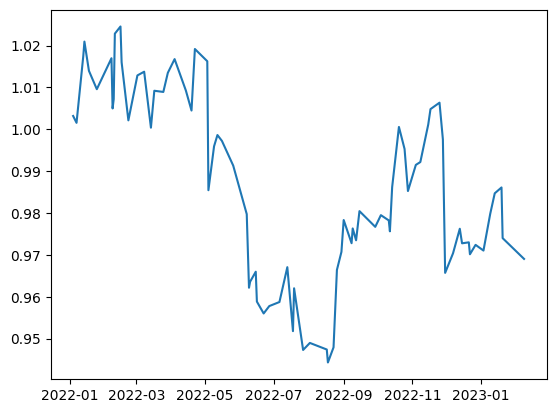

In [11]:
(retser + 1).sort_index().cumprod().plot()

# Inspect More Closely

In [15]:
!ls /home/memerling/dreamerv3-torch/logdir/$run/eval_eps | tail

20230621T111540-edf92c3184de4d68964003b4c859a7f7-326.npz
20230621T111541-90066e7f18294bd390f5dea106e733b8-326.npz
20230621T111543-6a5505aaacc84b9bba8c96b08fd350c7-326.npz
20230621T111545-cd3a1a2bc82b4403bd0e1e0cc9e87667-326.npz
20230621T111547-5e527309902546b696359b36d4ae1da2-326.npz
20230621T111548-8287966d1f5f4278bab5b3c39f28a2d2-326.npz
20230621T111550-1b67c96d27c24f26b715fcb462022d1b-326.npz
20230621T111552-9a5349dec5a34afa910e0ef601a9a8ff-326.npz
20230621T111553-33684d59640b4f1288c162c876ae546a-326.npz
20230621T111555-3861d32594e241baa8d8c8612b81a7c6-326.npz


In [12]:
agent = torch.load(f'/home/memerling/dreamerv3-torch/logdir/{run}/latest_model.pt')

In [13]:
agent

OrderedDict([('_wm._orig_mod.encoder._cnn.layers.0.weight',
              tensor([[[ 0.1647,  0.0775, -0.0300,  ...,  0.0816, -0.0377,  0.0095],
                       [ 0.0262,  0.0883,  0.0041,  ..., -0.0906, -0.0089, -0.0194],
                       [ 0.0113,  0.0819, -0.0209,  ..., -0.0984, -0.0341, -0.1311],
                       ...,
                       [-0.0503,  0.1633, -0.0395,  ..., -0.1426, -0.1337, -0.1259],
                       [ 0.0765, -0.1401,  0.1178,  ...,  0.0393, -0.0022, -0.1158],
                       [ 0.0306,  0.0298, -0.0900,  ..., -0.1012, -0.0600, -0.1919]],
              
                      [[ 0.1351, -0.0033,  0.0819,  ..., -0.1174, -0.2597,  0.0191],
                       [-0.0618,  0.0438, -0.1067,  ..., -0.0154,  0.2308,  0.0154],
                       [ 0.0526, -0.1587, -0.1676,  ..., -0.1263,  0.0112,  0.0912],
                       ...,
                       [ 0.2445,  0.2440,  0.1332,  ...,  0.0717,  0.0721,  0.1063],
                  

In [4]:
def filegen():
    yield from reversed(sorted(glob(f'logdir/{run}/eval_eps/*')))

In [5]:
episodes = filegen()

In [6]:
eval_eps = next(episodes)
eval_data = np.load(eval_eps)
print(pd.to_datetime(os.path.basename(eval_eps).split('-')[0]))

times = pd.to_datetime(eval_data['time'], utc=True).tz_convert('America/New_York')

pos = pd.Series(eval_data['pos'] - 1)
action = pos.diff()
action.iat[0] = pos.iloc[0]
action.index = times
action = action[action != 0]

date = times[-1].date()
start = pd.Timestamp.combine(date, datetime.time(hour=9, minute=30)).tz_localize('America/New_York')
end = pd.Timestamp.combine(date, datetime.time(hour=16)).tz_localize('America/New_York')
bars = api.get_bars('SPY', '1min',
                    start=start.isoformat(),
                    end=end.isoformat()).df
bars.index = bars.index.tz_convert('America/New_York')

ohlc = bars[['open', 'high', 'low', 'close']].mean(axis=1)

fig, ax = plt.subplots()
ohlc.plot(ax=ax, alpha=0.4)
ax.scatter(action.index, ohlc.loc[action.index], color=list(map({-1:'r', 1:'g'}.get, action)), s=10)
ax.set_title(f'{date}: {eval_data["reward"].sum()}')
plt.show()

2023-06-20 14:13:50


NameError: name 'api' is not defined